In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def scale_data(data_list):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    all_data = preprocessing.scale(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    # CMIP data    
    train = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_train.nc')
    label = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_label.nc')    
   
    train_sst = train['sst'][:, :12].values  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values
    train_ua = train['ua'][:, :12].values
    train_va = train['va'][:, :12].values
    train_label = label['nino'][:, 12:36].values

    train_ua = np.nan_to_num(train_ua) # trans nan to 0
    train_va = np.nan_to_num(train_va)
    train_t300 = np.nan_to_num(train_t300)
    train_sst = np.nan_to_num(train_sst)
    
    data_list = [train_sst,train_t300,train_ua,train_va]
    train_sst,train_t300,train_ua,train_va = scale_data(data_list)

    # SODA data    
    train2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    label2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    train_sst2 = train2['sst'][:, :12].values  # (100, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values
    train_ua2 = train2['ua'][:, :12].values
    train_va2 = train2['va'][:, :12].values
    train_label2 = label2['nino'][:, 12:36].values
    
    train_sst2 = np.nan_to_num(train_sst2) # trans nan to 0
    train_t3002 = np.nan_to_num(train_t3002)
    train_ua2 = np.nan_to_num(train_ua2)
    train_va2 = np.nan_to_num(train_va2)
    
    data_list = [train_sst2,train_t3002,train_ua2,train_va2]
    train_sst2,train_t3002,train_ua2,train_va2 = scale_data(data_list)

    print('Train samples: {}, Valid samples: {}'.format(len(train_label), len(train_label2)))

    dict_train = {
        'sst':train_sst,
        't300':train_t300,
        'ua':train_ua,
        'va': train_va,
        'label': train_label}
    dict_valid = {
        'sst':train_sst2,
        't300':train_t3002,
        'ua':train_ua2,
        'va': train_va2,
        'label': train_label2}
    train_dataset = EarthDataSet(dict_train)
    valid_dataset = EarthDataSet(dict_valid)
    return train_dataset, valid_dataset

In [6]:
set_seed()
train_dataset, valid_dataset = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

(96318720, 4)
(2073600, 4)
Train samples: 4645, Valid samples: 100


In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def train(num_epochs):
    best_score = -99
    loss_epoch = []
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):                
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%20 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
        y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        print('Epoch: {}, Valid Score: {}'.format(epoch+1,score))
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(25):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        plt.tight_layout()
        plt.show()
        

In [10]:
def gelu(x):
    """ Original Implementation of the gelu activation function in Google Bert repo when initialy created.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
        Also see https://arxiv.org/abs/1606.08415
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=gelu, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.mat = torch.matmul

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (self.mat(q, k.transpose(-2, -1))) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = self.mat(attn, v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
    
class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, proj_drop=0., attn_drop=0.,
                 drop_path=0., act_layer=gelu, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=proj_drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
#         self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=proj_drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


In [11]:
class CNN_Model(nn.Module):
    def __init__(self, embed_dim=128):
        super(CNN_Model, self).__init__()

        resnet = models.resnet18()
        resnet.conv1 = nn.Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), padding=(2, 4), bias=False)
        resnet.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
#         resnet.fc = nn.Linear(resnet.fc.in_features, 256)
        self.resnet = nn.Sequential(*(list(resnet.children())[:-1]))
#         self.lstm = nn.LSTM(input_size = 512, hidden_size = 128, num_layers=2, batch_first=True, bidirectional=True)
#         nn.MultiheadAttention(embed_dim = 512, num_heads = 8, dropout=0.0, bias=True)
        
        self.block = Block(dim=512, num_heads=8)
        self.norm = nn.LayerNorm(512)

        self.avgpool = nn.AvgPool1d(12)
        
        # Classifier head
        self.head = nn.Linear(512, 24)
        
    def forward_features(self, x):
        
        x = self.block(x)

        x = self.norm(x)
        return x

    def forward(self, sst, t300, ua, va):
        x = torch.cat([sst.unsqueeze(2), t300.unsqueeze(2), ua.unsqueeze(2), va.unsqueeze(2)], dim=2) # b * 12 * 4 * 24 * 72
        seq = []
        for t in range(x.shape[1]):
            t_i = x[:,t,:,:,:] # b * 4 * 24 * 72
            t_i = self.resnet(t_i).squeeze(-1).squeeze(-1) #  # b * 521
#             t_i = torch.flatten(t_i, start_dim=1)
            seq.append(t_i)
        x = torch.stack(seq).transpose(0,1) # b * 12 * 521
#         x, _ = self.lstm(x) # b * 12 * 128
#         x = x[:,-1]
        x = self.forward_features(x)
        x = self.avgpool(x.transpose(1,2)).squeeze(-1) # b * 512
        x = self.head(x)  # b * 24
        return x

In [12]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=8e-5)
loss_fn = nn.MSELoss()

model = model.to(device)
loss_fn = loss_fn.to(device)

In [13]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

CNN_Model : all params: 14.339480M


In [14]:
model

CNN_Model(
  (resnet): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), padding=(2, 4), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

Step: 0, Train Loss: 0.9856381416320801
Step: 20, Train Loss: 0.6526786684989929
Step: 40, Train Loss: 0.4629133641719818
Step: 60, Train Loss: 0.5864222049713135
Step: 80, Train Loss: 0.513856828212738
Step: 100, Train Loss: 0.5101292133331299
Step: 120, Train Loss: 0.46708330512046814
Step: 140, Train Loss: 0.6383287906646729
Epoch: 1, Train loss: 0.5895269749915764
acskill_socre:14.469155061304637, rmse_score:19.815674328617984
Epoch: 1, Valid Score: -5.346519267313347
Model saved successfully


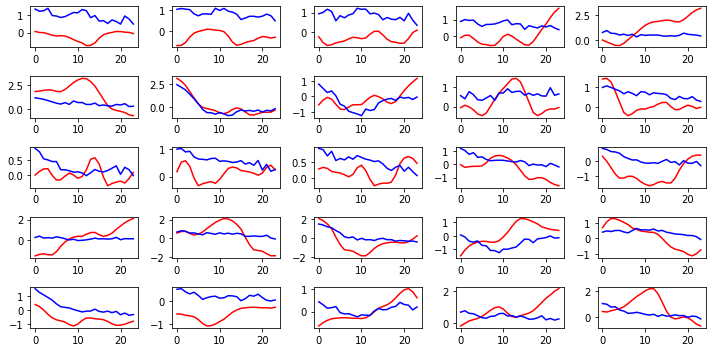

Step: 0, Train Loss: 0.417118638753891
Step: 20, Train Loss: 0.3442784249782562
Step: 40, Train Loss: 0.36207589507102966
Step: 60, Train Loss: 0.39648914337158203
Step: 80, Train Loss: 0.4757689833641052
Step: 100, Train Loss: 0.4766209125518799
Step: 120, Train Loss: 0.29623720049858093
Step: 140, Train Loss: 0.42308521270751953
Epoch: 2, Train loss: 0.41551997114534245
acskill_socre:19.04810995951287, rmse_score:20.446874952117504
Epoch: 2, Valid Score: -1.398764992604633
Model saved successfully


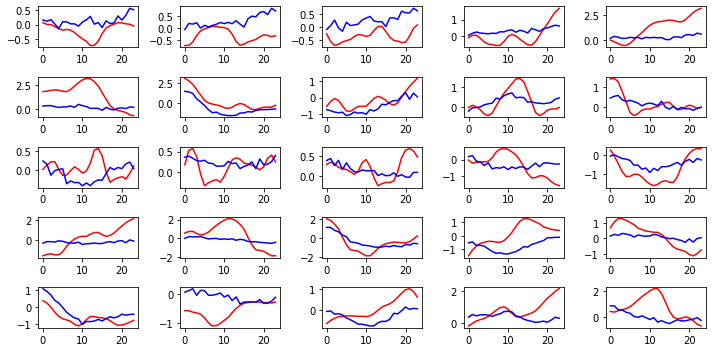

Step: 0, Train Loss: 0.24006149172782898
Step: 20, Train Loss: 0.2541884183883667
Step: 40, Train Loss: 0.2785840630531311
Step: 60, Train Loss: 0.16733846068382263
Step: 80, Train Loss: 0.2669672966003418
Step: 100, Train Loss: 0.30315354466438293
Step: 120, Train Loss: 0.315420001745224
Step: 140, Train Loss: 0.31316623091697693
Epoch: 3, Train loss: 0.25407464628758497
acskill_socre:15.438496798715406, rmse_score:21.742207797894213
Epoch: 3, Valid Score: -6.303710999178808


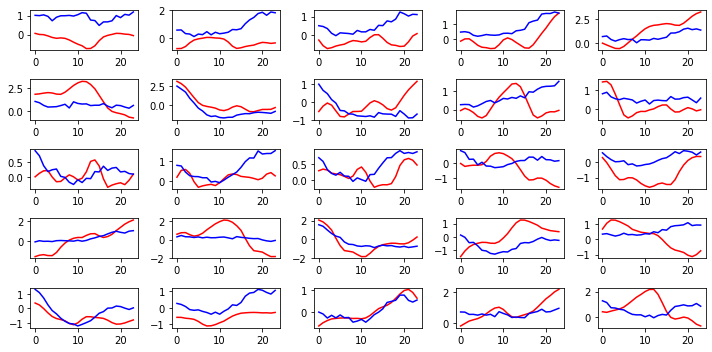

Step: 0, Train Loss: 0.19600361585617065
Step: 20, Train Loss: 0.1695091724395752
Step: 40, Train Loss: 0.15855422616004944
Step: 60, Train Loss: 0.1318235993385315
Step: 80, Train Loss: 0.11239412426948547
Step: 100, Train Loss: 0.15608784556388855
Step: 120, Train Loss: 0.09198248386383057
Step: 140, Train Loss: 0.1416303813457489
Epoch: 4, Train loss: 0.1597419437276174
acskill_socre:18.66465068120917, rmse_score:22.26355803456842
Epoch: 4, Valid Score: -3.598907353359248


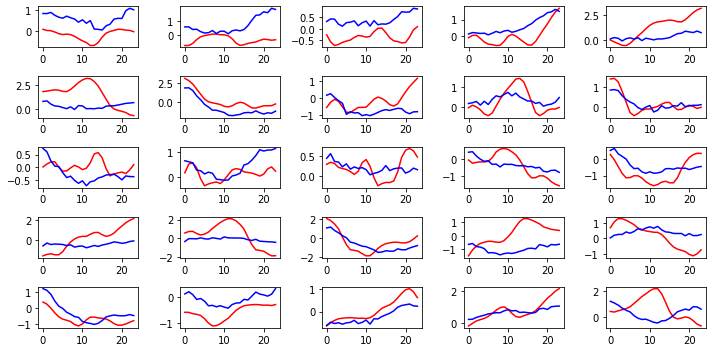

Step: 0, Train Loss: 0.13286098837852478
Step: 20, Train Loss: 0.13884079456329346
Step: 40, Train Loss: 0.1254260540008545
Step: 60, Train Loss: 0.14261069893836975
Step: 80, Train Loss: 0.0846104621887207
Step: 100, Train Loss: 0.07840082794427872
Step: 120, Train Loss: 0.11617168039083481
Step: 140, Train Loss: 0.09433154761791229
Epoch: 5, Train loss: 0.09794558158578122
acskill_socre:16.47353408656188, rmse_score:20.3785017367894
Epoch: 5, Valid Score: -3.904967650227519


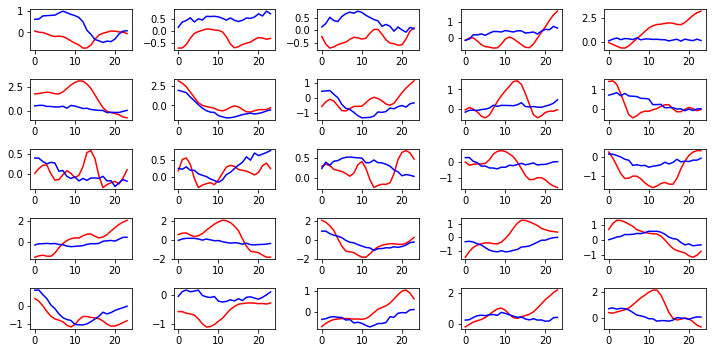

Step: 0, Train Loss: 0.09602877497673035
Step: 20, Train Loss: 0.0757121667265892
Step: 40, Train Loss: 0.05943823605775833
Step: 60, Train Loss: 0.06301990896463394
Step: 80, Train Loss: 0.05739296227693558
Step: 100, Train Loss: 0.07713373750448227
Step: 120, Train Loss: 0.06653817743062973
Step: 140, Train Loss: 0.07413440942764282
Epoch: 6, Train loss: 0.07539103545044383
acskill_socre:17.691380122358204, rmse_score:20.92763639835712
Epoch: 6, Valid Score: -3.2362562759989153


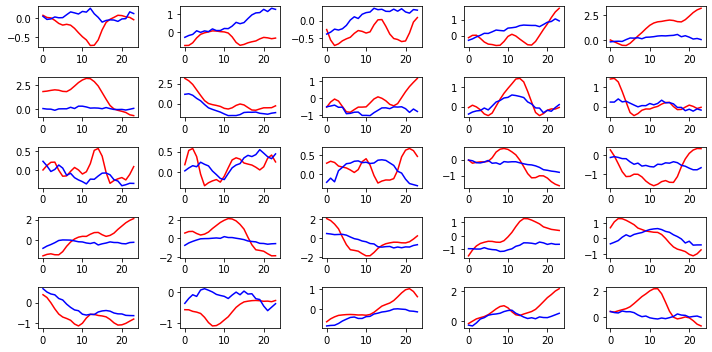

Step: 0, Train Loss: 0.05199811980128288
Step: 20, Train Loss: 0.06887739151716232
Step: 40, Train Loss: 0.06802576035261154
Step: 60, Train Loss: 0.08924831449985504
Step: 80, Train Loss: 0.0564899817109108
Step: 100, Train Loss: 0.06360725313425064
Step: 120, Train Loss: 0.05741460621356964
Step: 140, Train Loss: 0.05717230588197708
Epoch: 7, Train loss: 0.06443402083105829
acskill_socre:20.048318068082068, rmse_score:22.96590012340517
Epoch: 7, Valid Score: -2.917582055323102


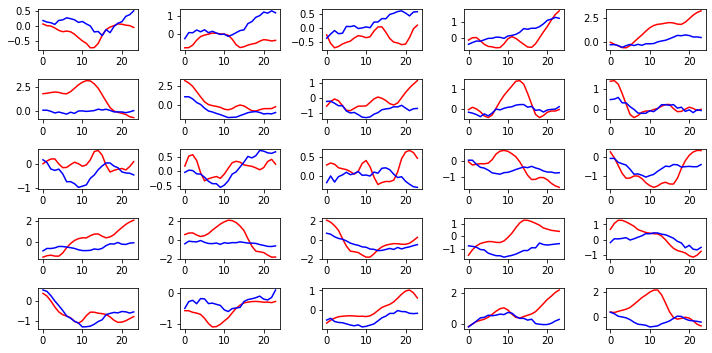

Step: 0, Train Loss: 0.04230392724275589
Step: 20, Train Loss: 0.07877521216869354
Step: 40, Train Loss: 0.05864614248275757
Step: 60, Train Loss: 0.05053870379924774
Step: 80, Train Loss: 0.08849821984767914
Step: 100, Train Loss: 0.04920314997434616
Step: 120, Train Loss: 0.08089771121740341
Step: 140, Train Loss: 0.062106817960739136
Epoch: 8, Train loss: 0.06365759737075191
acskill_socre:19.27208408603316, rmse_score:21.008072145631118
Epoch: 8, Valid Score: -1.7359880595979575


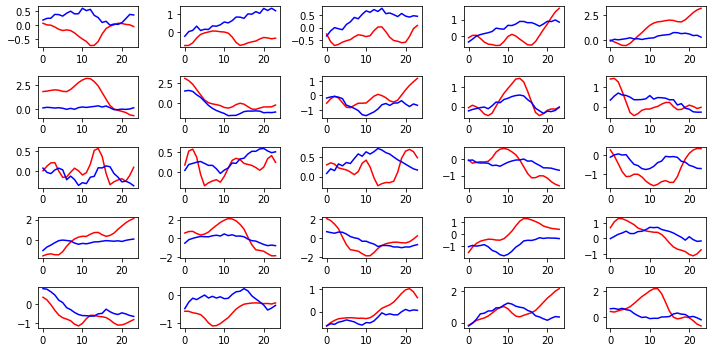

Step: 0, Train Loss: 0.05510525032877922
Step: 20, Train Loss: 0.055016644299030304
Step: 40, Train Loss: 0.06082959473133087
Step: 60, Train Loss: 0.05094835162162781
Step: 80, Train Loss: 0.04260760545730591
Step: 100, Train Loss: 0.042622536420822144
Step: 120, Train Loss: 0.0639098733663559
Step: 140, Train Loss: 0.06484819948673248
Epoch: 9, Train loss: 0.05949172599572841
acskill_socre:20.34276306040871, rmse_score:20.69092524085918
Epoch: 9, Valid Score: -0.3481621804504691
Model saved successfully


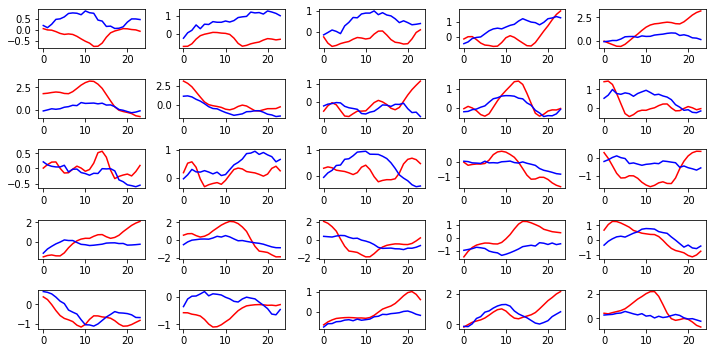

Step: 0, Train Loss: 0.043992072343826294
Step: 20, Train Loss: 0.05491387099027634
Step: 40, Train Loss: 0.05385644733905792
Step: 60, Train Loss: 0.03284652158617973
Step: 80, Train Loss: 0.054937392473220825
Step: 100, Train Loss: 0.048232972621917725
Step: 120, Train Loss: 0.052027106285095215
Step: 140, Train Loss: 0.047525178641080856
Epoch: 10, Train loss: 0.05483417822788023
acskill_socre:18.18373633937486, rmse_score:21.51705016151474
Epoch: 10, Valid Score: -3.3333138221398784


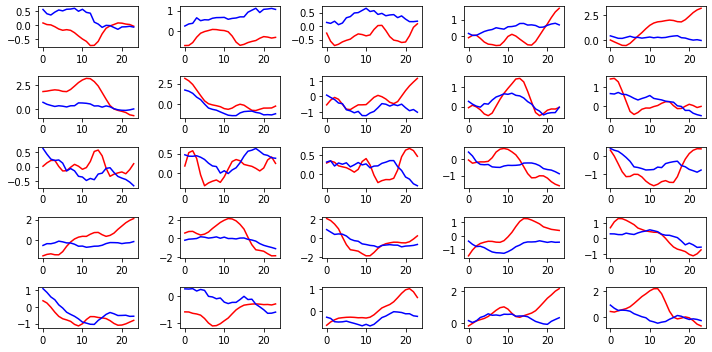

Step: 0, Train Loss: 0.043679118156433105
Step: 20, Train Loss: 0.057793520390987396
Step: 40, Train Loss: 0.048116397112607956
Step: 60, Train Loss: 0.03918830305337906
Step: 80, Train Loss: 0.06220762059092522
Step: 100, Train Loss: 0.05609413981437683
Step: 120, Train Loss: 0.050390686839818954
Step: 140, Train Loss: 0.07638087123632431
Epoch: 11, Train loss: 0.0543601597238281
acskill_socre:21.251102368794285, rmse_score:21.721072403812176
Epoch: 11, Valid Score: -0.4699700350178908


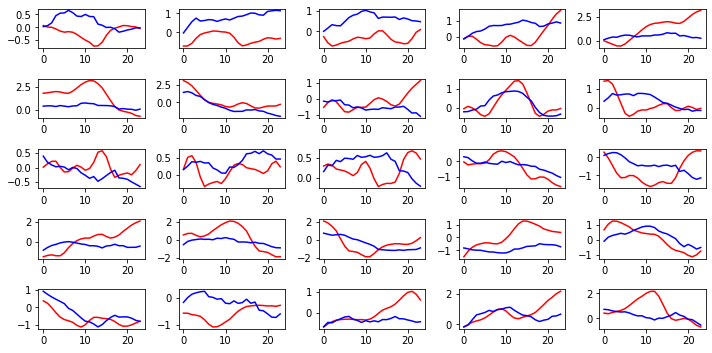

Step: 0, Train Loss: 0.06644202768802643
Step: 20, Train Loss: 0.06758185476064682
Step: 40, Train Loss: 0.05110708996653557
Step: 60, Train Loss: 0.035042356699705124
Step: 80, Train Loss: 0.05777484178543091
Step: 100, Train Loss: 0.07185085862874985
Step: 120, Train Loss: 0.028922077268362045
Step: 140, Train Loss: 0.06323862075805664
Epoch: 12, Train loss: 0.05303162183255365
acskill_socre:19.889218328950705, rmse_score:20.988211281804016
Epoch: 12, Valid Score: -1.0989929528533118


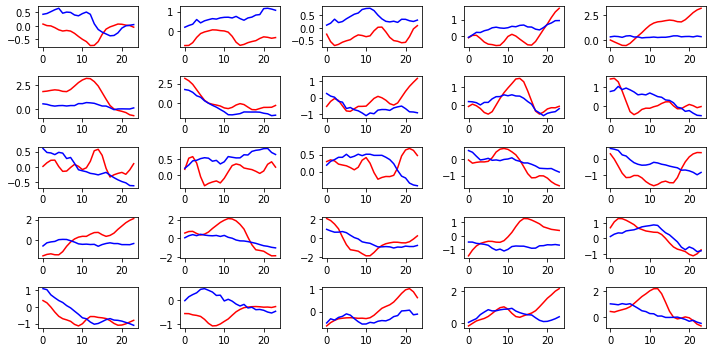

Step: 0, Train Loss: 0.040904201567173004
Step: 20, Train Loss: 0.0542454831302166
Step: 40, Train Loss: 0.03005545400083065
Step: 60, Train Loss: 0.04207156226038933
Step: 80, Train Loss: 0.03280435502529144
Step: 100, Train Loss: 0.05001399666070938
Step: 120, Train Loss: 0.05145466327667236
Step: 140, Train Loss: 0.0521610789000988
Epoch: 13, Train loss: 0.050218217585184806
acskill_socre:19.31393040284002, rmse_score:21.269923193808086
Epoch: 13, Valid Score: -1.955992790968068


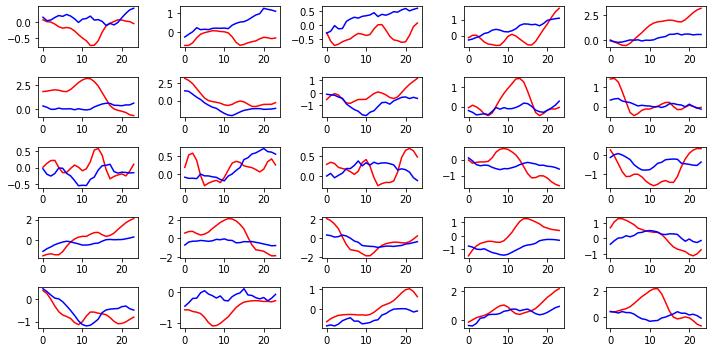

Step: 0, Train Loss: 0.04799304157495499
Step: 20, Train Loss: 0.07012881338596344
Step: 40, Train Loss: 0.057497452944517136
Step: 60, Train Loss: 0.07182414829730988
Step: 80, Train Loss: 0.04488053172826767
Step: 100, Train Loss: 0.04188486188650131
Step: 120, Train Loss: 0.04965117573738098
Step: 140, Train Loss: 0.061412885785102844
Epoch: 14, Train loss: 0.05038474037069572
acskill_socre:22.478395956750646, rmse_score:21.233237902025117
Epoch: 14, Valid Score: 1.245158054725529
Model saved successfully


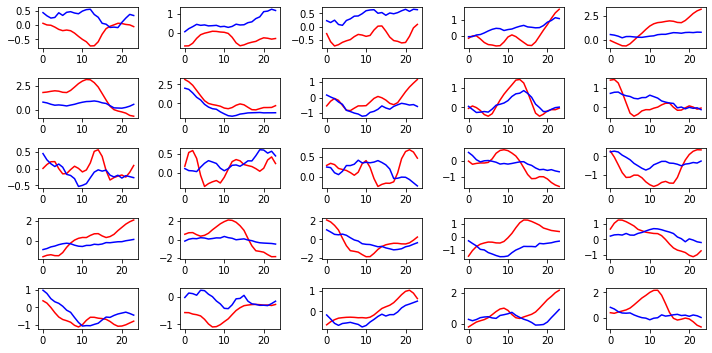

Step: 0, Train Loss: 0.03643970564007759
Step: 20, Train Loss: 0.052730660885572433
Step: 40, Train Loss: 0.041753530502319336
Step: 60, Train Loss: 0.03210054710507393
Step: 80, Train Loss: 0.025209110230207443
Step: 100, Train Loss: 0.0712229460477829
Step: 120, Train Loss: 0.03520051762461662
Step: 140, Train Loss: 0.03532237559556961
Epoch: 15, Train loss: 0.04916403491101037
acskill_socre:18.177085464352615, rmse_score:20.231592355542052
Epoch: 15, Valid Score: -2.054506891189437


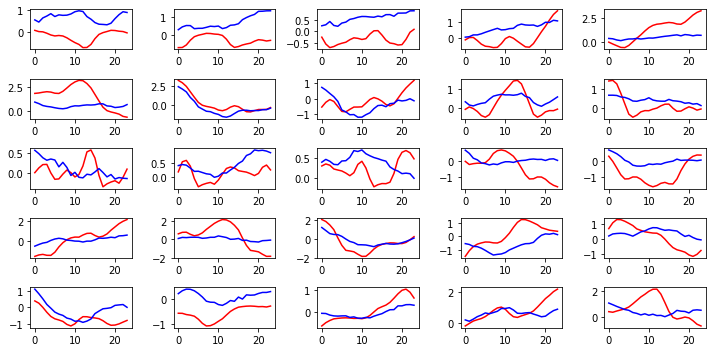

Step: 0, Train Loss: 0.03415520861744881
Step: 20, Train Loss: 0.037646517157554626
Step: 40, Train Loss: 0.03899792954325676
Step: 60, Train Loss: 0.03843362256884575
Step: 80, Train Loss: 0.04516599699854851
Step: 100, Train Loss: 0.03612522780895233
Step: 120, Train Loss: 0.05719609186053276
Step: 140, Train Loss: 0.04477208852767944
Epoch: 16, Train loss: 0.04595057468555153
acskill_socre:20.616163053985666, rmse_score:19.51307750344802
Epoch: 16, Valid Score: 1.1030855505376458


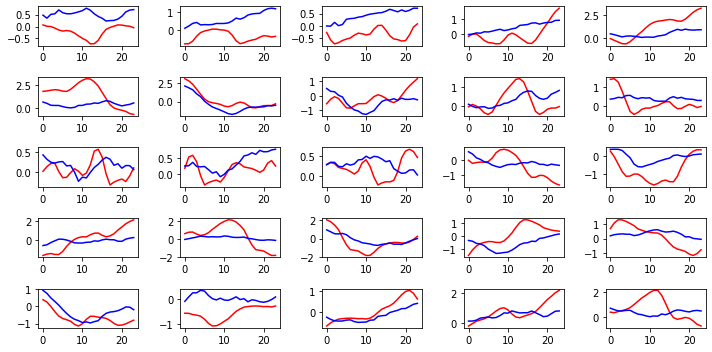

Step: 0, Train Loss: 0.03707148879766464
Step: 20, Train Loss: 0.06238717958331108
Step: 40, Train Loss: 0.03395497053861618
Step: 60, Train Loss: 0.0489327609539032
Step: 80, Train Loss: 0.02879580482840538
Step: 100, Train Loss: 0.04668086767196655
Step: 120, Train Loss: 0.05560615286231041
Step: 140, Train Loss: 0.03531661629676819
Epoch: 17, Train loss: 0.04322742145151308
acskill_socre:17.53917733923364, rmse_score:19.778254901137448
Epoch: 17, Valid Score: -2.239077561903809


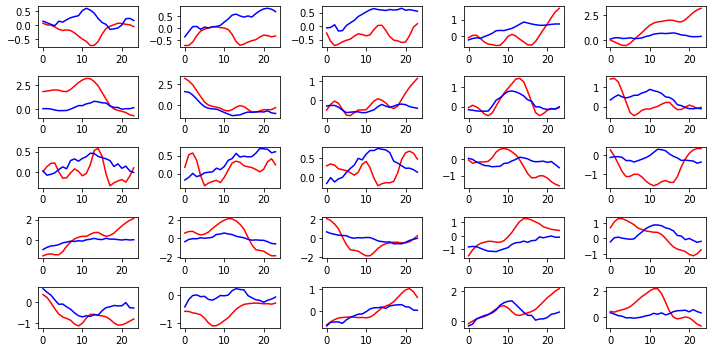

Step: 0, Train Loss: 0.05301417037844658
Step: 20, Train Loss: 0.06988581269979477
Step: 40, Train Loss: 0.061205919831991196
Step: 60, Train Loss: 0.03206224367022514
Step: 80, Train Loss: 0.08095578849315643
Step: 100, Train Loss: 0.03466960787773132
Step: 120, Train Loss: 0.03837447613477707
Step: 140, Train Loss: 0.08422651141881943
Epoch: 18, Train loss: 0.04558227082382735
acskill_socre:20.651116640132063, rmse_score:20.42660018250835
Epoch: 18, Valid Score: 0.22451645762371442


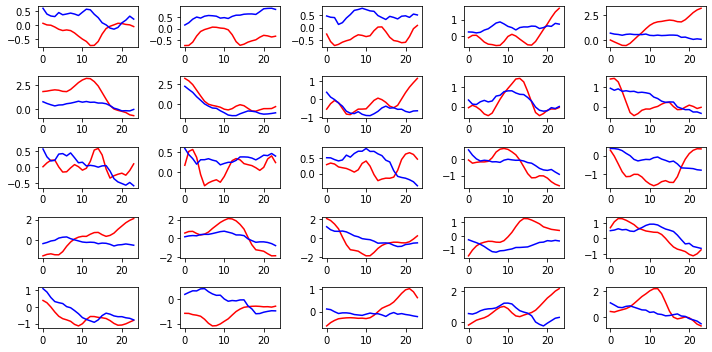

Step: 0, Train Loss: 0.03361485153436661
Step: 20, Train Loss: 0.09184801578521729
Step: 40, Train Loss: 0.02747352421283722
Step: 60, Train Loss: 0.03433172032237053
Step: 80, Train Loss: 0.03268622234463692
Step: 100, Train Loss: 0.029072578996419907
Step: 120, Train Loss: 0.03459560498595238
Step: 140, Train Loss: 0.03718555346131325
Epoch: 19, Train loss: 0.04684599323121652
acskill_socre:18.73882127002074, rmse_score:20.945731876079417
Epoch: 19, Valid Score: -2.2069106060586776


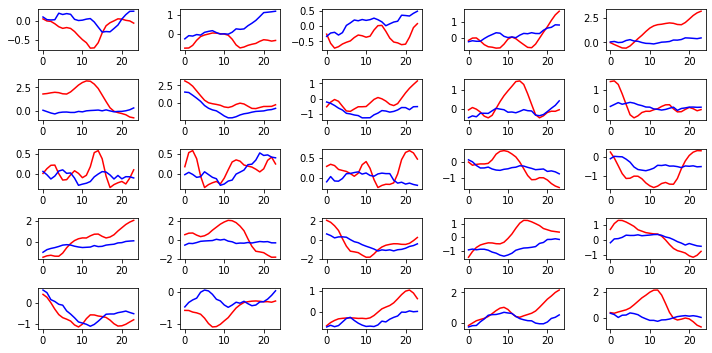

Step: 0, Train Loss: 0.03997264802455902
Step: 20, Train Loss: 0.048023760318756104
Step: 40, Train Loss: 0.027973130345344543
Step: 60, Train Loss: 0.06687625497579575
Step: 80, Train Loss: 0.03679896146059036
Step: 100, Train Loss: 0.022188058122992516
Step: 120, Train Loss: 0.037332382053136826
Step: 140, Train Loss: 0.0476950965821743
Epoch: 20, Train loss: 0.04509057850921399
acskill_socre:16.556268371144284, rmse_score:19.399362628710985
Epoch: 20, Valid Score: -2.843094257566701


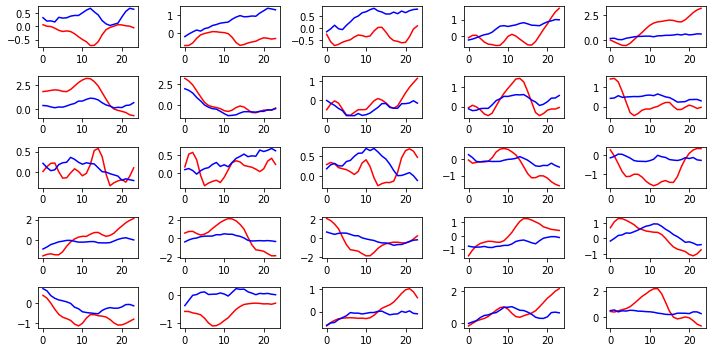

Step: 0, Train Loss: 0.03998645395040512
Step: 20, Train Loss: 0.032251618802547455
Step: 40, Train Loss: 0.054411545395851135
Step: 60, Train Loss: 0.03422660380601883
Step: 80, Train Loss: 0.04977047070860863
Step: 100, Train Loss: 0.022087400779128075
Step: 120, Train Loss: 0.021158188581466675
Step: 140, Train Loss: 0.030891170725226402
Epoch: 21, Train loss: 0.04225449408213162
acskill_socre:16.393038610745805, rmse_score:20.64531791669207
Epoch: 21, Valid Score: -4.252279305946264


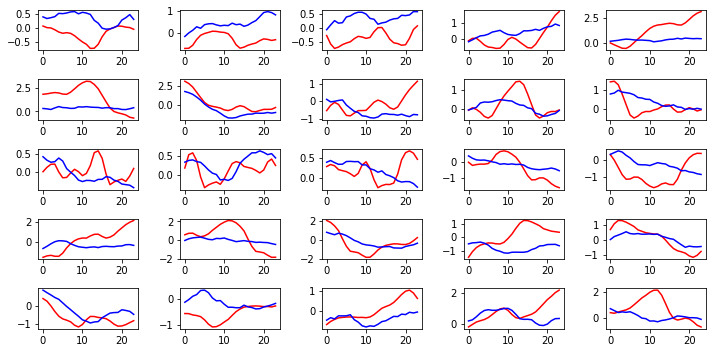

Step: 0, Train Loss: 0.04903204366564751
Step: 20, Train Loss: 0.04827345162630081
Step: 40, Train Loss: 0.023244980722665787
Step: 60, Train Loss: 0.040406689047813416
Step: 80, Train Loss: 0.05018947646021843
Step: 100, Train Loss: 0.04112084209918976
Step: 120, Train Loss: 0.029171045869588852
Step: 140, Train Loss: 0.02945461869239807
Epoch: 22, Train loss: 0.040301769206376924
acskill_socre:20.097965867707252, rmse_score:19.983790678296867
Epoch: 22, Valid Score: 0.11417518941038551


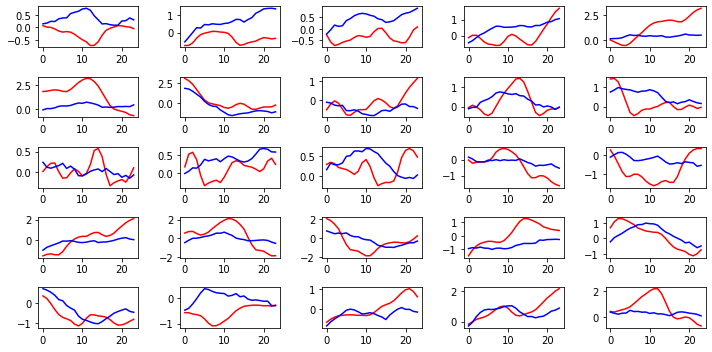

Step: 0, Train Loss: 0.0514955036342144
Step: 20, Train Loss: 0.03976460546255112
Step: 40, Train Loss: 0.03704879432916641
Step: 60, Train Loss: 0.02633393369615078
Step: 80, Train Loss: 0.03626106679439545
Step: 100, Train Loss: 0.04907253384590149
Step: 120, Train Loss: 0.0232678409665823
Step: 140, Train Loss: 0.03253577649593353
Epoch: 23, Train loss: 0.0374793379044492
acskill_socre:18.714109186537883, rmse_score:20.112624532233404
Epoch: 23, Valid Score: -1.3985153456955217


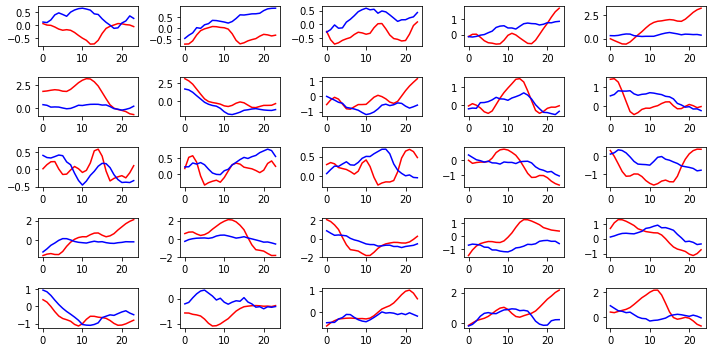

Step: 0, Train Loss: 0.04534349963068962
Step: 20, Train Loss: 0.03685874864459038
Step: 40, Train Loss: 0.023963909596204758
Step: 60, Train Loss: 0.020018447190523148
Step: 80, Train Loss: 0.03743782266974449
Step: 100, Train Loss: 0.026165593415498734
Step: 120, Train Loss: 0.03165050595998764
Step: 140, Train Loss: 0.03950730711221695
Epoch: 24, Train loss: 0.03781990040961194
acskill_socre:18.292886536306902, rmse_score:20.95189296747935
Epoch: 24, Valid Score: -2.659006431172447


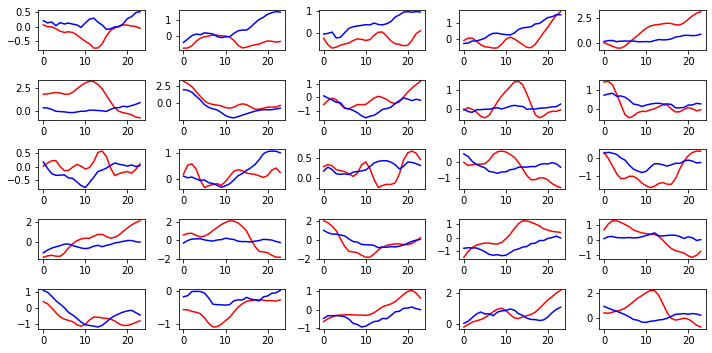

Step: 0, Train Loss: 0.02142791450023651
Step: 20, Train Loss: 0.026224520057439804
Step: 40, Train Loss: 0.032126396894454956
Step: 60, Train Loss: 0.028718795627355576
Step: 80, Train Loss: 0.035935308784246445
Step: 100, Train Loss: 0.03530357778072357
Step: 120, Train Loss: 0.03210829570889473
Step: 140, Train Loss: 0.029127422720193863
Epoch: 25, Train loss: 0.03497127888800755
acskill_socre:16.252608636553745, rmse_score:20.501400427888676
Epoch: 25, Valid Score: -4.248791791334931


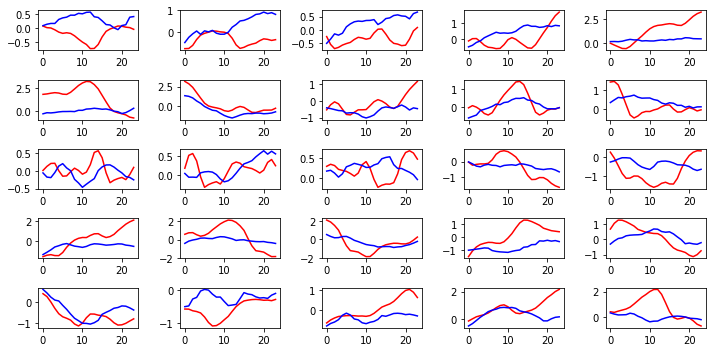

Step: 0, Train Loss: 0.03135114908218384
Step: 20, Train Loss: 0.05496401712298393
Step: 40, Train Loss: 0.04579448327422142
Step: 60, Train Loss: 0.028216030448675156
Step: 80, Train Loss: 0.04425516724586487
Step: 100, Train Loss: 0.03137393295764923
Step: 120, Train Loss: 0.055709369480609894
Step: 140, Train Loss: 0.023233141750097275
Epoch: 26, Train loss: 0.039528342040434275
acskill_socre:19.16266889704722, rmse_score:20.44415521360767
Epoch: 26, Valid Score: -1.28148631656045


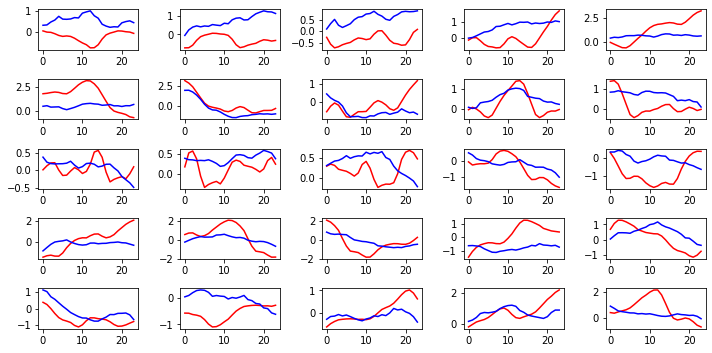

Step: 0, Train Loss: 0.052187852561473846
Step: 20, Train Loss: 0.03962269425392151
Step: 40, Train Loss: 0.05791813135147095
Step: 60, Train Loss: 0.033091552555561066
Step: 80, Train Loss: 0.0468263253569603
Step: 100, Train Loss: 0.03279148042201996
Step: 120, Train Loss: 0.029465368017554283
Step: 140, Train Loss: 0.03854050487279892
Epoch: 27, Train loss: 0.03850968302010673
acskill_socre:15.943065241135294, rmse_score:20.892090030531815
Epoch: 27, Valid Score: -4.949024789396521


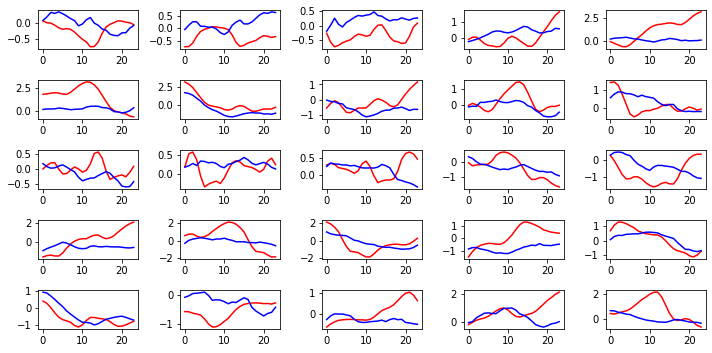

Step: 0, Train Loss: 0.04062715545296669
Step: 20, Train Loss: 0.03714507818222046
Step: 40, Train Loss: 0.04157675802707672
Step: 60, Train Loss: 0.04278179258108139
Step: 80, Train Loss: 0.03888361528515816
Step: 100, Train Loss: 0.02690458856523037
Step: 120, Train Loss: 0.029396232217550278
Step: 140, Train Loss: 0.024350587278604507
Epoch: 28, Train loss: 0.036911222369295275
acskill_socre:17.925452758306616, rmse_score:20.43639116739698
Epoch: 28, Valid Score: -2.5109384090903646


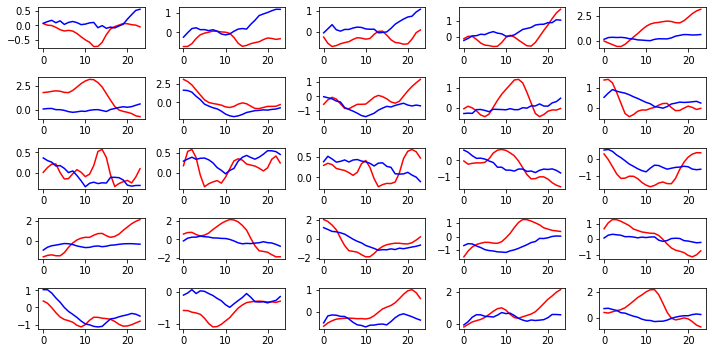

Step: 0, Train Loss: 0.05793145298957825
Step: 20, Train Loss: 0.060253486037254333
Step: 40, Train Loss: 0.052487023174762726
Step: 60, Train Loss: 0.020962193608283997
Step: 80, Train Loss: 0.024086667224764824
Step: 100, Train Loss: 0.0276410561054945
Step: 120, Train Loss: 0.034737251698970795
Step: 140, Train Loss: 0.026280581951141357
Epoch: 29, Train loss: 0.03710984882630714
acskill_socre:17.979797945128063, rmse_score:19.62243275509541
Epoch: 29, Valid Score: -1.6426348099673476


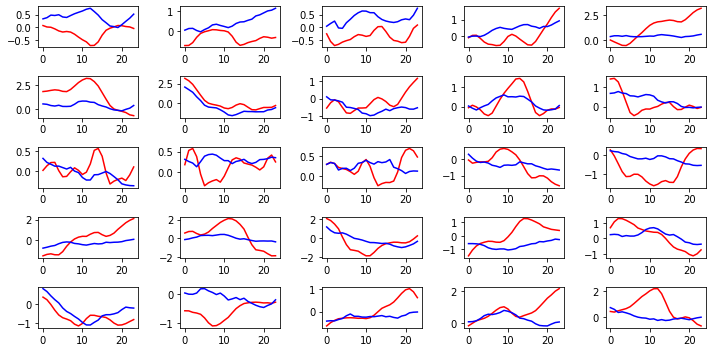

Step: 0, Train Loss: 0.03977035731077194
Step: 20, Train Loss: 0.041512630879879
Step: 40, Train Loss: 0.032417066395282745
Step: 60, Train Loss: 0.028825916349887848
Step: 80, Train Loss: 0.028897499665617943
Step: 100, Train Loss: 0.032235294580459595
Step: 120, Train Loss: 0.028528591617941856
Step: 140, Train Loss: 0.025538688525557518
Epoch: 30, Train loss: 0.03557184452114448
acskill_socre:17.542680721280195, rmse_score:21.01484732130222
Epoch: 30, Valid Score: -3.4721666000220246


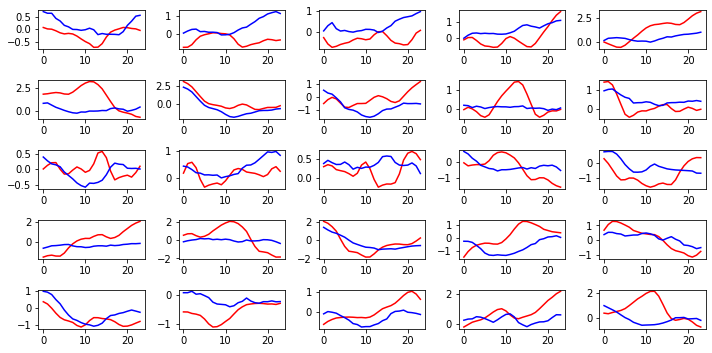

Step: 0, Train Loss: 0.02231523022055626
Step: 20, Train Loss: 0.03371291607618332
Step: 40, Train Loss: 0.022880805656313896
Step: 60, Train Loss: 0.031464532017707825
Step: 80, Train Loss: 0.028912371024489403
Step: 100, Train Loss: 0.03221439570188522
Step: 120, Train Loss: 0.029528802260756493
Step: 140, Train Loss: 0.02105722576379776
Epoch: 31, Train loss: 0.03253256241242363
acskill_socre:18.34791178591651, rmse_score:19.87398260921705
Epoch: 31, Valid Score: -1.5260708233005431


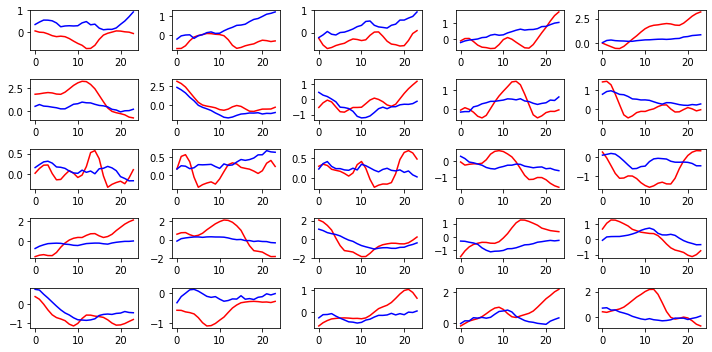

Step: 0, Train Loss: 0.028778985142707825
Step: 20, Train Loss: 0.020395828410983086
Step: 40, Train Loss: 0.03120356798171997
Step: 60, Train Loss: 0.02544168382883072
Step: 80, Train Loss: 0.029444484040141106
Step: 100, Train Loss: 0.026932820677757263
Step: 120, Train Loss: 0.018773533403873444
Step: 140, Train Loss: 0.027280455455183983
Epoch: 32, Train loss: 0.03028196433227356
acskill_socre:19.354871810028456, rmse_score:20.35404812824672
Epoch: 32, Valid Score: -0.9991763182182645


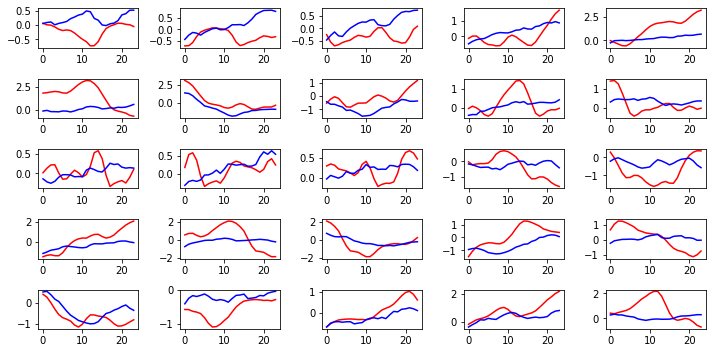

Step: 0, Train Loss: 0.040886424481868744
Step: 20, Train Loss: 0.027008038014173508
Step: 40, Train Loss: 0.040093038231134415
Step: 60, Train Loss: 0.028579292818903923
Step: 80, Train Loss: 0.02904924564063549
Step: 100, Train Loss: 0.028870265930891037
Step: 120, Train Loss: 0.01649106852710247
Step: 140, Train Loss: 0.033913224935531616
Epoch: 33, Train loss: 0.030588396352856127
acskill_socre:20.31143052345619, rmse_score:20.29822777776896
Epoch: 33, Valid Score: 0.013202745687227235


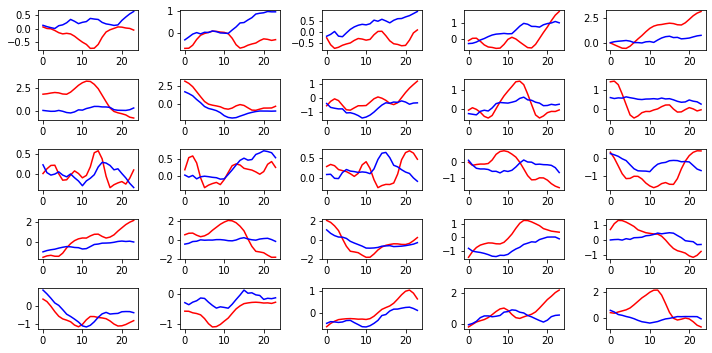

Step: 0, Train Loss: 0.026936650276184082
Step: 20, Train Loss: 0.03855260834097862
Step: 40, Train Loss: 0.020272091031074524
Step: 60, Train Loss: 0.029929108917713165
Step: 80, Train Loss: 0.024724898859858513
Step: 100, Train Loss: 0.024305200204253197
Step: 120, Train Loss: 0.03057265281677246
Step: 140, Train Loss: 0.0170131828635931
Epoch: 34, Train loss: 0.029023156858572405
acskill_socre:19.69479070261371, rmse_score:19.866748848646054
Epoch: 34, Valid Score: -0.17195814603234538


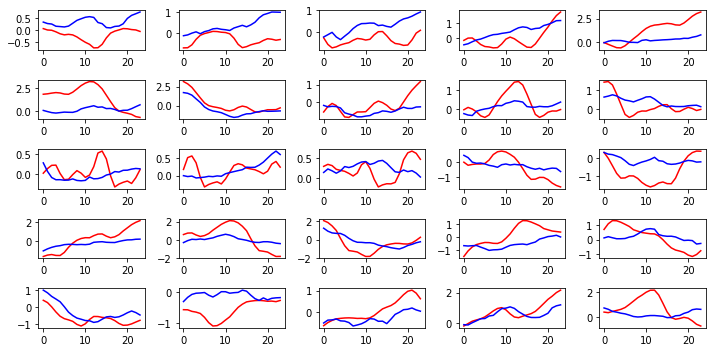

Step: 0, Train Loss: 0.03361831232905388
Step: 20, Train Loss: 0.030487587675452232
Step: 40, Train Loss: 0.035933464765548706
Step: 60, Train Loss: 0.02583250217139721
Step: 80, Train Loss: 0.034942567348480225
Step: 100, Train Loss: 0.028758645057678223
Step: 120, Train Loss: 0.024168606847524643
Step: 140, Train Loss: 0.021206965669989586
Epoch: 35, Train loss: 0.0335765779273559
acskill_socre:17.108546417585952, rmse_score:20.67120775736626
Epoch: 35, Valid Score: -3.562661339780309


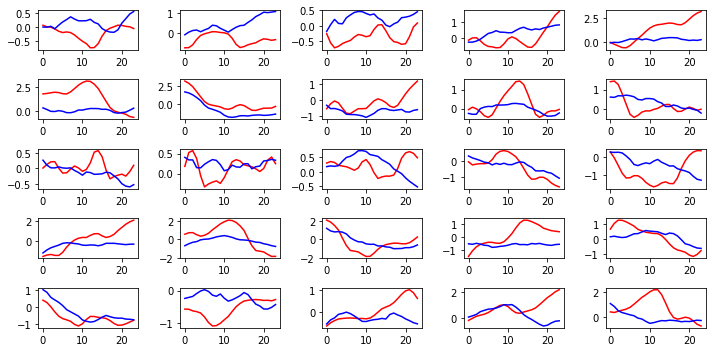

Step: 0, Train Loss: 0.024469874799251556
Step: 20, Train Loss: 0.017532572150230408
Step: 40, Train Loss: 0.039642415940761566
Step: 60, Train Loss: 0.025355864316225052
Step: 80, Train Loss: 0.028645193204283714
Step: 100, Train Loss: 0.020869074389338493
Step: 120, Train Loss: 0.038477830588817596
Step: 140, Train Loss: 0.02418290637433529
Epoch: 36, Train loss: 0.03298080990677827
acskill_socre:17.343848101131343, rmse_score:19.71252885102556
Epoch: 36, Valid Score: -2.3686807498942173


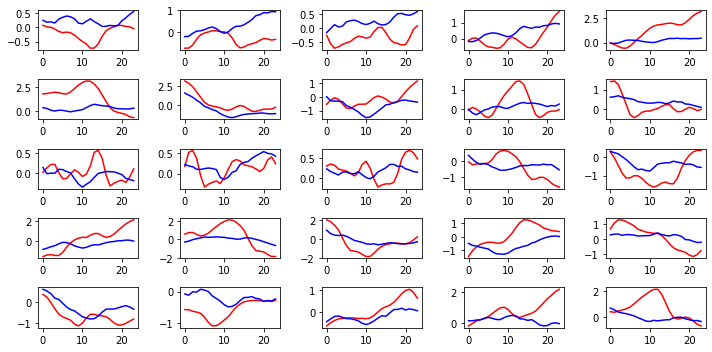

Step: 0, Train Loss: 0.03061375766992569
Step: 20, Train Loss: 0.037105631083250046
Step: 40, Train Loss: 0.02614055946469307
Step: 60, Train Loss: 0.02768731117248535
Step: 80, Train Loss: 0.04203132912516594
Step: 100, Train Loss: 0.0341857448220253
Step: 120, Train Loss: 0.019379112869501114
Step: 140, Train Loss: 0.033358510583639145
Epoch: 37, Train loss: 0.03283678480002978
acskill_socre:17.685191776813152, rmse_score:20.1466705024806
Epoch: 37, Valid Score: -2.4614787256674475


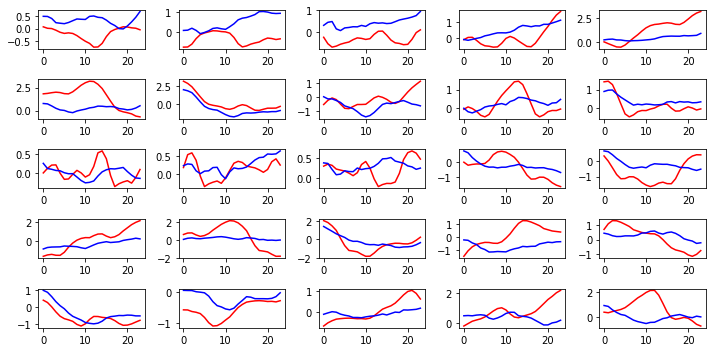

Step: 0, Train Loss: 0.034258805215358734
Step: 20, Train Loss: 0.028506554663181305
Step: 40, Train Loss: 0.0395037978887558
Step: 60, Train Loss: 0.024008385837078094
Step: 80, Train Loss: 0.028984373435378075
Step: 100, Train Loss: 0.04659227654337883
Step: 120, Train Loss: 0.021385155618190765
Step: 140, Train Loss: 0.02078741416335106
Epoch: 38, Train loss: 0.03132051644106842
acskill_socre:20.64785017807494, rmse_score:20.918046377376697
Epoch: 38, Valid Score: -0.27019619930175764


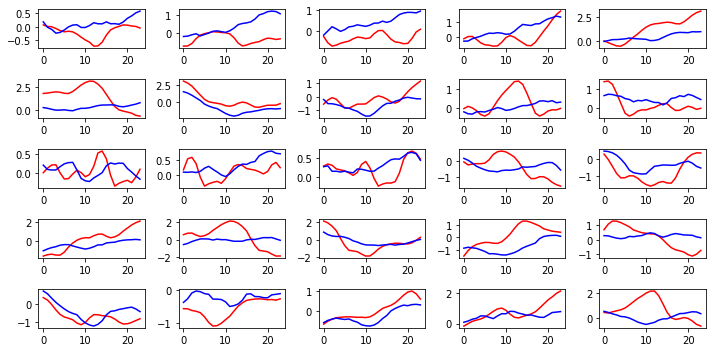

Step: 0, Train Loss: 0.02941327542066574
Step: 20, Train Loss: 0.026541341096162796
Step: 40, Train Loss: 0.027200495824217796
Step: 60, Train Loss: 0.02788873016834259
Step: 80, Train Loss: 0.02682533860206604
Step: 100, Train Loss: 0.05385495349764824
Step: 120, Train Loss: 0.023515716195106506
Step: 140, Train Loss: 0.01995973289012909
Epoch: 39, Train loss: 0.03023283693888416
acskill_socre:17.864465662152526, rmse_score:19.701961058371122
Epoch: 39, Valid Score: -1.8374953962185963


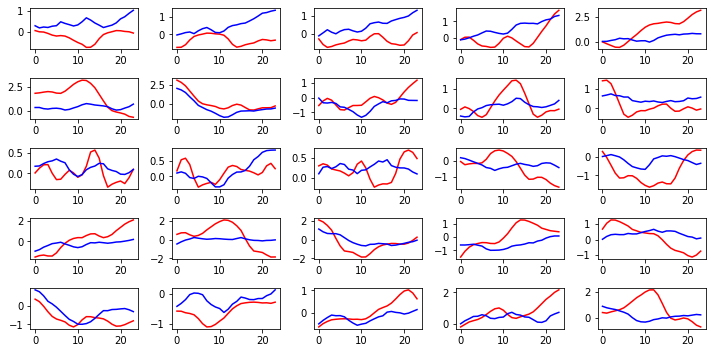

Step: 0, Train Loss: 0.021455993875861168
Step: 20, Train Loss: 0.03510909527540207
Step: 40, Train Loss: 0.02364293858408928
Step: 60, Train Loss: 0.02393580786883831
Step: 80, Train Loss: 0.021098509430885315
Step: 100, Train Loss: 0.02652529440820217
Step: 120, Train Loss: 0.02044229581952095
Step: 140, Train Loss: 0.02251928113400936
Epoch: 40, Train loss: 0.027984429144440857
acskill_socre:15.484827855234851, rmse_score:19.59999648862384
Epoch: 40, Valid Score: -4.11516863338899


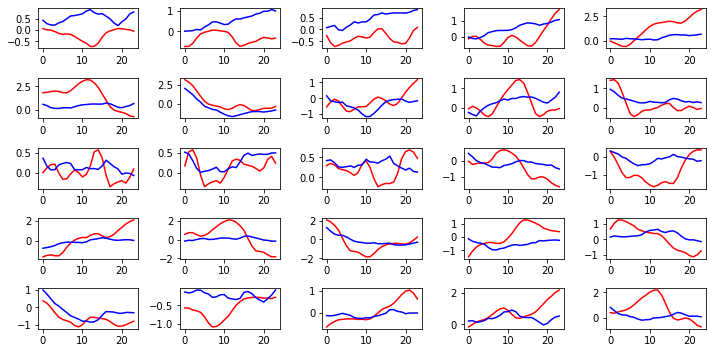

Step: 0, Train Loss: 0.02739911898970604
Step: 20, Train Loss: 0.02418922446668148
Step: 40, Train Loss: 0.028104161843657494
Step: 60, Train Loss: 0.028254900127649307
Step: 80, Train Loss: 0.02348891645669937
Step: 100, Train Loss: 0.02723068557679653
Step: 120, Train Loss: 0.03378930315375328
Step: 140, Train Loss: 0.02233710139989853
Epoch: 41, Train loss: 0.027422189533914607
acskill_socre:15.911511169934458, rmse_score:20.422136044451136
Epoch: 41, Valid Score: -4.510624874516678


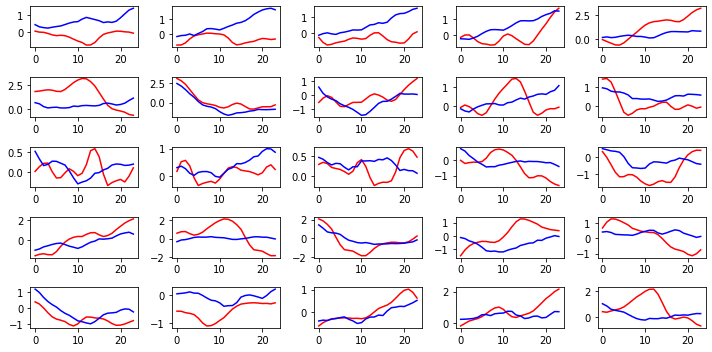

Step: 0, Train Loss: 0.028635641559958458
Step: 20, Train Loss: 0.04675006866455078
Step: 40, Train Loss: 0.023195719346404076
Step: 60, Train Loss: 0.023738643154501915
Step: 80, Train Loss: 0.023364117369055748
Step: 100, Train Loss: 0.03788934648036957
Step: 120, Train Loss: 0.0303497314453125
Step: 140, Train Loss: 0.022503454238176346
Epoch: 42, Train loss: 0.02654004202237072
acskill_socre:14.936322777975153, rmse_score:20.56493612382876
Epoch: 42, Valid Score: -5.628613345853605


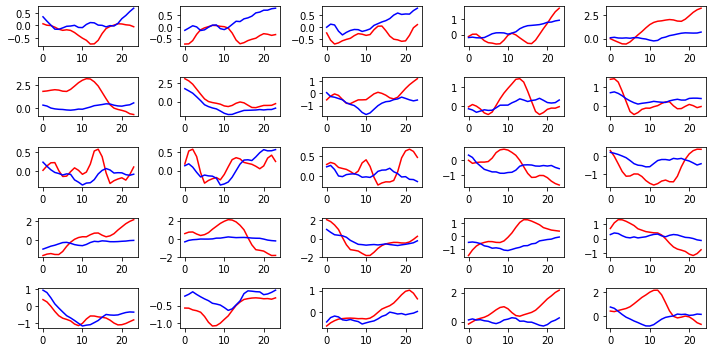

Step: 0, Train Loss: 0.026286756619811058
Step: 20, Train Loss: 0.025346746668219566
Step: 40, Train Loss: 0.031131520867347717
Step: 60, Train Loss: 0.03115539252758026
Step: 80, Train Loss: 0.02093018963932991
Step: 100, Train Loss: 0.031100040301680565
Step: 120, Train Loss: 0.020765356719493866
Step: 140, Train Loss: 0.016545914113521576
Epoch: 43, Train loss: 0.027003404595059892
acskill_socre:18.3950966453289, rmse_score:19.306312961620314
Epoch: 43, Valid Score: -0.9112163162914158


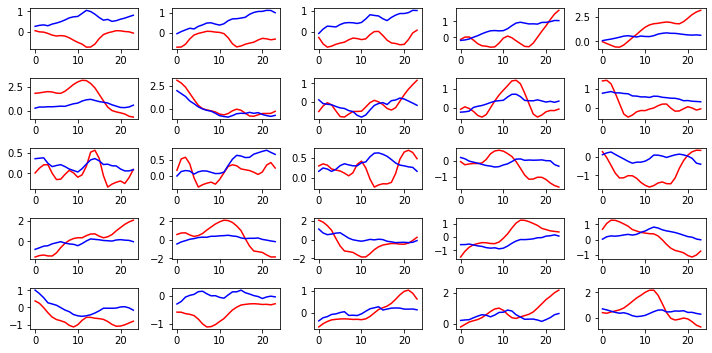

Step: 0, Train Loss: 0.01848120614886284
Step: 20, Train Loss: 0.03061777725815773
Step: 40, Train Loss: 0.03806820139288902
Step: 60, Train Loss: 0.03409857302904129
Step: 80, Train Loss: 0.019398145377635956
Step: 100, Train Loss: 0.021863218396902084
Step: 120, Train Loss: 0.03027833066880703
Step: 140, Train Loss: 0.029548615217208862
Epoch: 44, Train loss: 0.02809491541797984
acskill_socre:17.690658504298575, rmse_score:19.80373499076114
Epoch: 44, Valid Score: -2.113076486462564


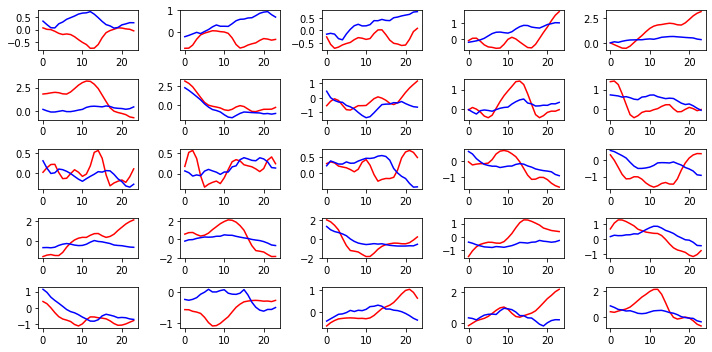

Step: 0, Train Loss: 0.023823395371437073
Step: 20, Train Loss: 0.037329841405153275
Step: 40, Train Loss: 0.037806905806064606
Step: 60, Train Loss: 0.019655441865324974
Step: 80, Train Loss: 0.01982658915221691
Step: 100, Train Loss: 0.02668774500489235
Step: 120, Train Loss: 0.027050165459513664
Step: 140, Train Loss: 0.025811543688178062
Epoch: 45, Train loss: 0.02609868054852298
acskill_socre:17.54372504382492, rmse_score:20.332009437808587
Epoch: 45, Valid Score: -2.788284393983666


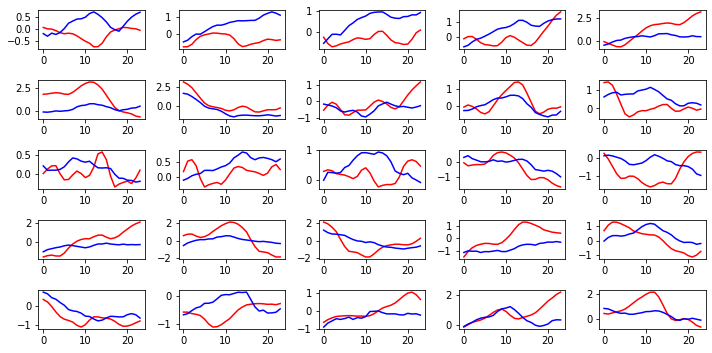

Step: 0, Train Loss: 0.03454555571079254
Step: 20, Train Loss: 0.02454025112092495
Step: 40, Train Loss: 0.020568067207932472
Step: 60, Train Loss: 0.02031264826655388
Step: 80, Train Loss: 0.024351973086595535
Step: 100, Train Loss: 0.020845433697104454
Step: 120, Train Loss: 0.038361433893442154
Step: 140, Train Loss: 0.026021724566817284
Epoch: 46, Train loss: 0.023245574007040425
acskill_socre:16.933605047358267, rmse_score:19.704546601715567
Epoch: 46, Valid Score: -2.7709415543573


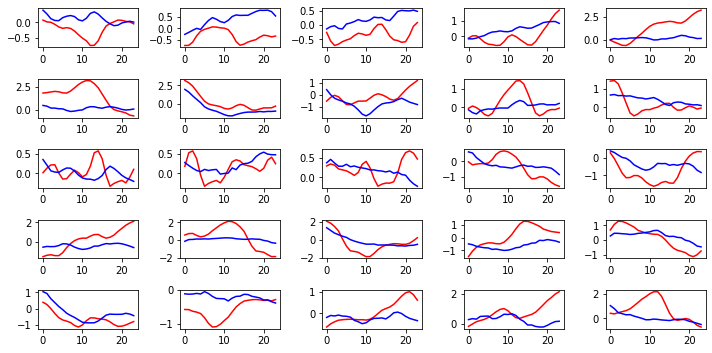

Step: 0, Train Loss: 0.027817508205771446
Step: 20, Train Loss: 0.017124546691775322
Step: 40, Train Loss: 0.019285669550299644
Step: 60, Train Loss: 0.021271120756864548
Step: 80, Train Loss: 0.023514052852988243
Step: 100, Train Loss: 0.017595982179045677
Step: 120, Train Loss: 0.017589790746569633
Step: 140, Train Loss: 0.016769200563430786
Epoch: 47, Train loss: 0.023174238563451455
acskill_socre:14.017109295322054, rmse_score:20.00686046698849
Epoch: 47, Valid Score: -5.989751171666434


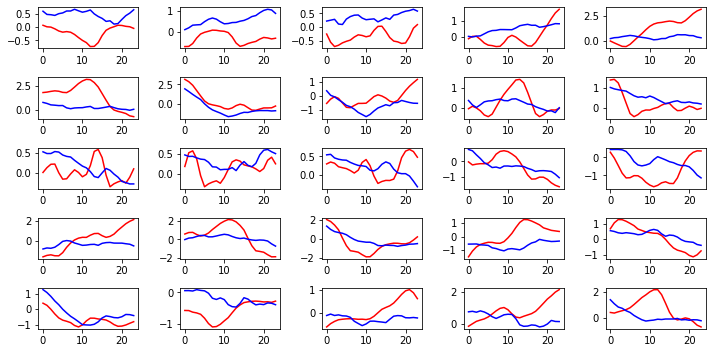

Step: 0, Train Loss: 0.018671002238988876
Step: 20, Train Loss: 0.01863803341984749
Step: 40, Train Loss: 0.021871646866202354
Step: 60, Train Loss: 0.02457970380783081
Step: 80, Train Loss: 0.024080511182546616
Step: 100, Train Loss: 0.024462521076202393
Step: 120, Train Loss: 0.021553218364715576
Step: 140, Train Loss: 0.019400857388973236
Epoch: 48, Train loss: 0.02310732521805657
acskill_socre:16.028900388378773, rmse_score:20.048971395641807
Epoch: 48, Valid Score: -4.020071007263034


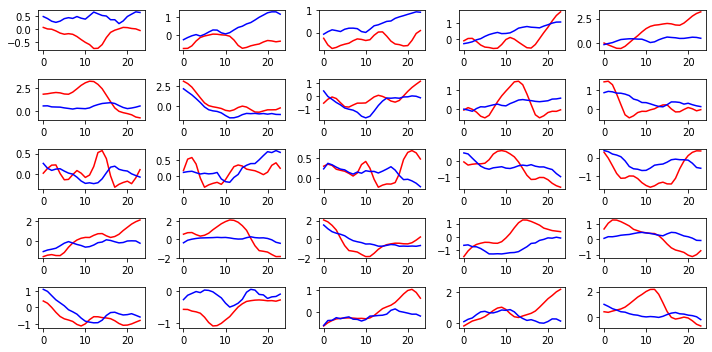

Step: 0, Train Loss: 0.02275261841714382
Step: 20, Train Loss: 0.029435355216264725
Step: 40, Train Loss: 0.021975575014948845
Step: 60, Train Loss: 0.019638294354081154
Step: 80, Train Loss: 0.02042960934340954
Step: 100, Train Loss: 0.022507179528474808
Step: 120, Train Loss: 0.022900542244315147
Step: 140, Train Loss: 0.019367415457963943
Epoch: 49, Train loss: 0.021211358909941698
acskill_socre:16.641543795173426, rmse_score:19.939376948160028
Epoch: 49, Valid Score: -3.297833152986602


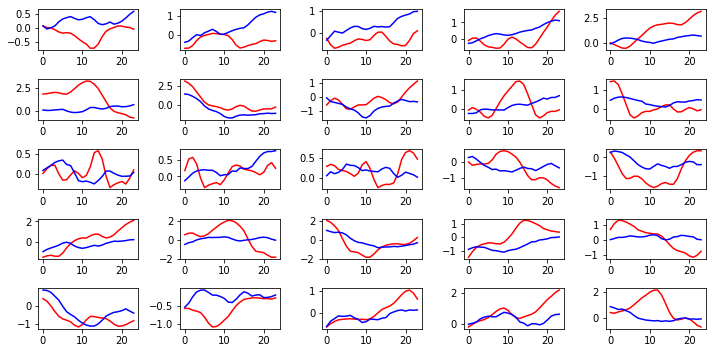

Step: 0, Train Loss: 0.017605353146791458
Step: 20, Train Loss: 0.01478999387472868
Step: 40, Train Loss: 0.02235235832631588
Step: 60, Train Loss: 0.022169439122080803
Step: 80, Train Loss: 0.022424418479204178
Step: 100, Train Loss: 0.01465453952550888
Step: 120, Train Loss: 0.016291402280330658
Step: 140, Train Loss: 0.015255298465490341
Epoch: 50, Train loss: 0.020489453937705248
acskill_socre:18.640853876588004, rmse_score:20.00426304979073
Epoch: 50, Valid Score: -1.3634091732027258


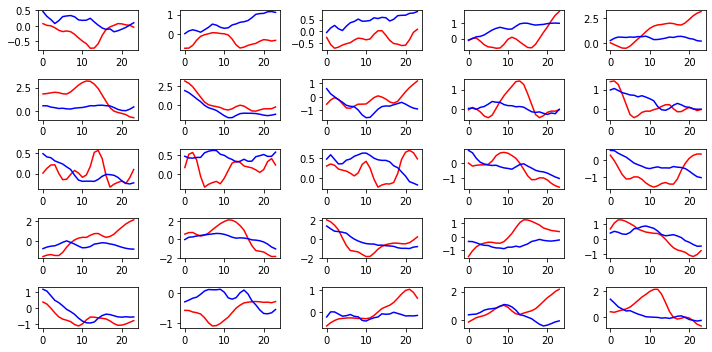

In [15]:
train(num_epochs=50)

In [94]:
model.load_state_dict(torch.load('models/basemodel_epoch_5.pt'))

<All keys matched successfully>

In [15]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [17]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
    data_list = [SST,T300,Ua,Va]
    SST,T300,Ua,Va = scale_data(data_list)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

(20736, 4)


In [9]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [44]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [45]:
make_zip()

./result/test_0144-01-12.npy
